In [11]:
%load_ext autoreload
%autoreload 2
%matplotlib agg

import visualization
from data import datasets
import numpy as np
import jax
import jax.numpy as jnp
from jax.tree_util import tree_map, tree_flatten, tree_unflatten, tree_leaves
from typing import Sequence
from functools import reduce
from itertools import combinations_with_replacement, product
from transformation import MLP
from utils import MLPSymmetryHelper
import flax.linen as nn
from flax.core import unfreeze
import matplotlib.pyplot as plt
rng_key = jax.random.PRNGKey(0)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


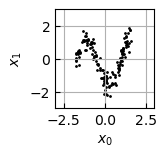

In [12]:
# load dataset
rng_key, rng_key_ = jax.random.split(rng_key)
dataset = datasets.Sinusoidal(normalization="standardization", rng_key=rng_key_, x_lower=0.0, x_upper=8.0)
X, y = dataset[:]

# visualization
figure = visualization.TriangleFigure(prefix="x", settings=visualization.TriangleSettings(univariate=False))
figure.plot(data=dataset.data)

In [13]:
# load samples
samples_parameters = np.load("test.npy")
print(samples_parameters.shape)

(4096, 10)


In [14]:
neural_network = MLP([3, 1], activation=nn.tanh)

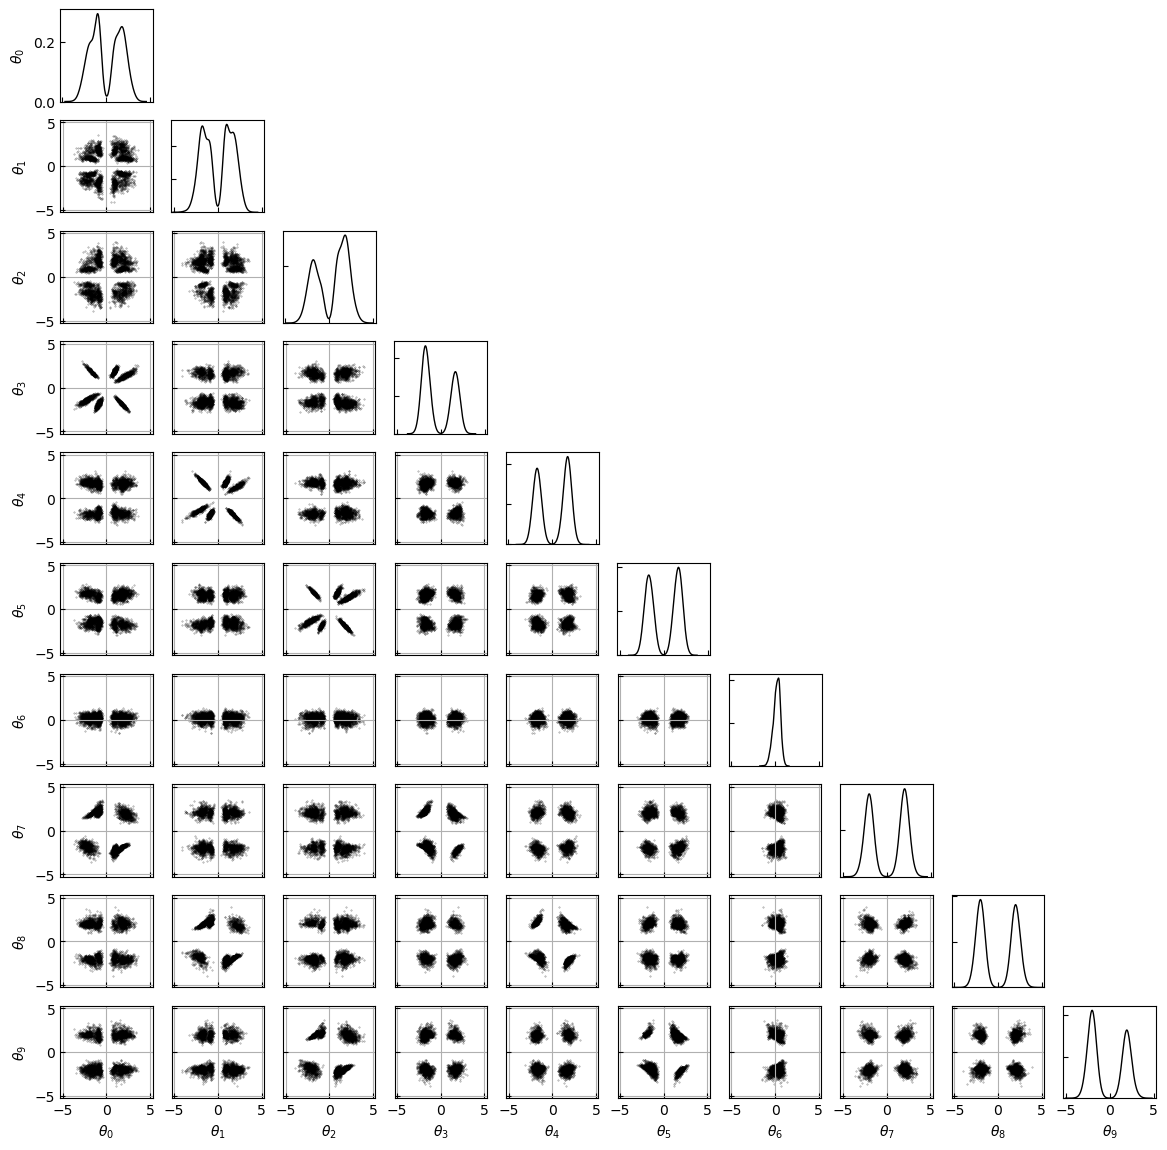

In [15]:
figure = visualization.TriangleFigure(
    prefix=r"\theta",
    settings=visualization.TriangleSettings(
        scatter_settings=visualization.ScatterSettings(alpha=0.5, size=0.1)
    )
)
figure.plot(data=samples_parameters)

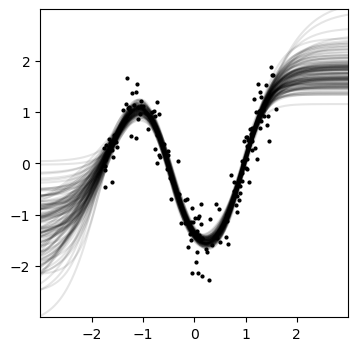

In [16]:
figure = visualization.RegressionFigure(
    settings=visualization.RegressionSettings(
        transformation_plot_settings=visualization.TransformationPlotSettings(alpha=0.1)
    )
)
figure.plot(data=dataset.data, transformation=neural_network.apply_from_vector, parameters=samples_parameters[:128], std=0.1)

In [17]:
sh = MLPSymmetryHelper(
    parameters_shapes=unfreeze(tree_map(lambda x: np.array(x.shape), neural_network.init_from_vector(inputs=X[0], parameters_vector=samples_parameters[0]))),
    activation_function="tanh"
)

In [18]:
activation_symmetries = sh.activation_symmetries()
permutation_symmetries = sh.permutation_symmetries()
for asym in activation_symmetries:
    print(asym)

for psym in permutation_symmetries:
    print(psym)

[[-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. -1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. -1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. -1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0. -1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0. -1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. -1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. -1.]]
[[-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. -1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. -1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0. -1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. -1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]]
[[-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. -1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.

In [19]:
# maybe the three clusters have different NN representations for fitting the data. Investigate!

In [20]:
mirrored_parameters_samples = []
for i, parameters_sample in enumerate(samples_parameters):
    mirrored_parameters_sample = parameters_sample.copy()
    
    # MLP ([3, 1])
    # permutation symmetries
    biases_1 = mirrored_parameters_sample[0:3]
    kernel_1 = mirrored_parameters_sample[3:6]
    kernel_2 = mirrored_parameters_sample[7:]
    
    biases_1_indices_sort = np.argsort(biases_1)
    biases_1 = biases_1[biases_1_indices_sort]
    kernel_1 = kernel_1[biases_1_indices_sort]
    kernel_2 = kernel_2[biases_1_indices_sort]
    
    mirrored_parameters_sample[0:3] = biases_1
    mirrored_parameters_sample[3:6] = kernel_1
    mirrored_parameters_sample[7:] = kernel_2
    
    # tanh symmetries
    if mirrored_parameters_sample[3] < 0.0:
        mirrored_parameters_sample[[0, 3, 7]] *= -1.0
    if mirrored_parameters_sample[4] < 0.0:
        mirrored_parameters_sample[[1, 4, 8]] *= -1.0
    if mirrored_parameters_sample[5] < 0.0:
        mirrored_parameters_sample[[2, 5, 9]] *= -1.0
    
    # permutation symmetries
    biases_1 = mirrored_parameters_sample[0:3]
    kernel_1 = mirrored_parameters_sample[3:6]
    kernel_2 = mirrored_parameters_sample[7:]
    
    biases_1_indices_sort = np.argsort(biases_1)
    biases_1 = biases_1[biases_1_indices_sort]
    kernel_1 = kernel_1[biases_1_indices_sort]
    kernel_2 = kernel_2[biases_1_indices_sort]
    
    mirrored_parameters_sample[0:3] = biases_1
    mirrored_parameters_sample[3:6] = kernel_1
    mirrored_parameters_sample[7:] = kernel_2
    
    mirrored_parameters_samples.append(mirrored_parameters_sample)
mirrored_parameters_samples = np.stack(mirrored_parameters_samples, axis=0)

In [32]:
mirrored_parameters_samples = sh.remove_tanh_symmetries(samples_parameters)
mirrored_parameters_samples = sh.remove_permutation_symmetries(mirrored_parameters_samples)

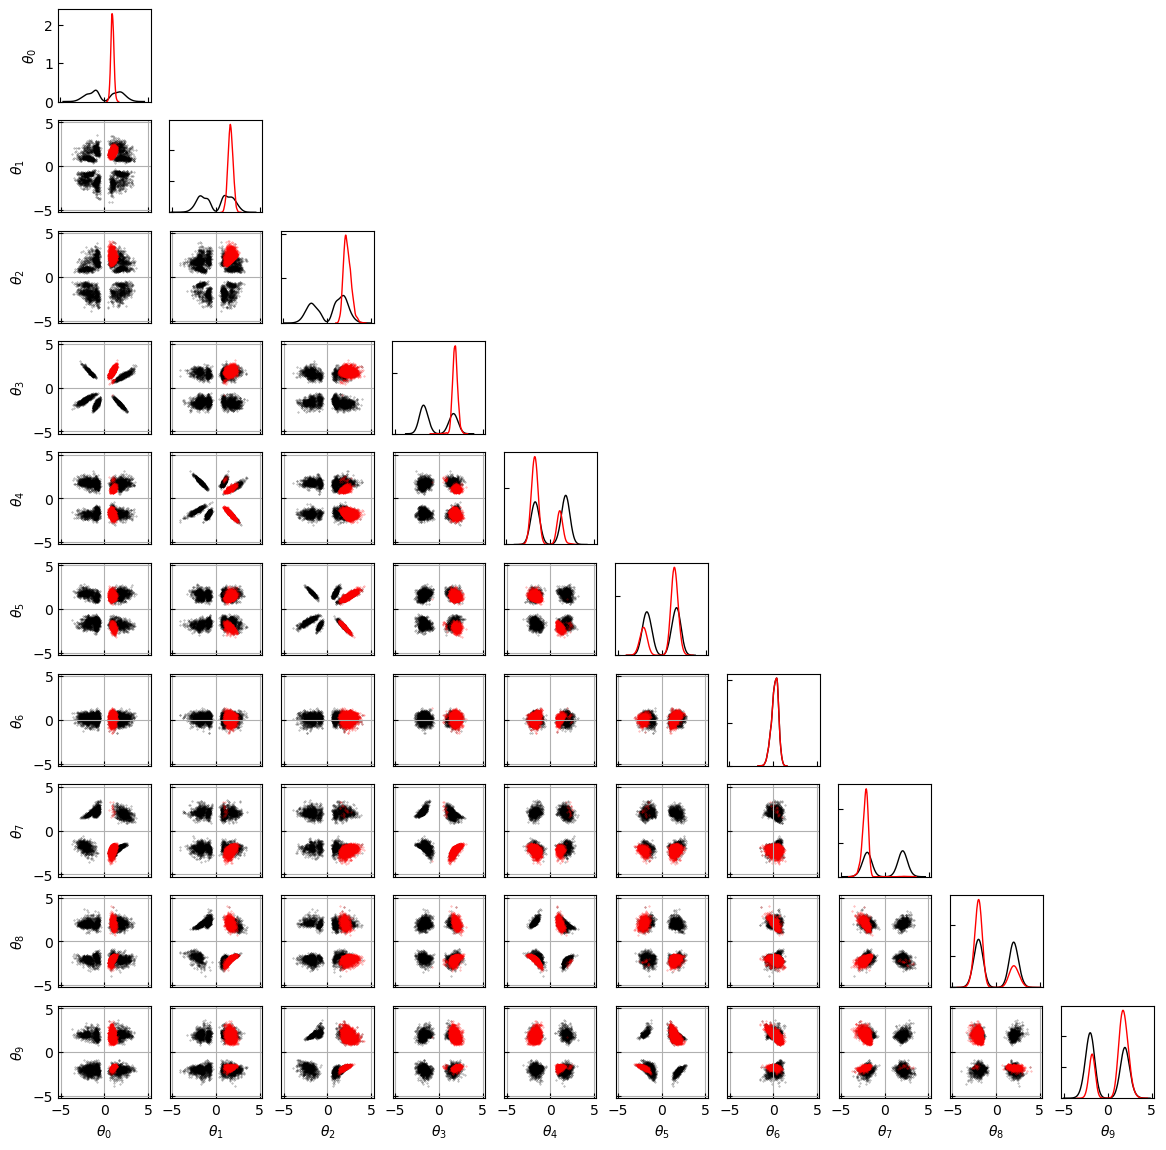

In [33]:
figure = visualization.TriangleFigure(
    prefix=r"\theta",
    settings=visualization.TriangleSettings(
        scatter_settings=visualization.ScatterSettings(alpha=0.5, size=0.1)
    )
)
figure.plot(data=samples_parameters, data_2=mirrored_parameters_samples)

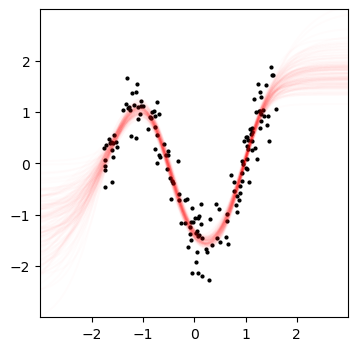

In [34]:
figure = visualization.RegressionFigure(
    settings=visualization.RegressionSettings(
        transformation_plot_settings=visualization.TransformationPlotSettings(alpha=0.01, color="red")
    )
)
figure.plot(data=dataset.data, transformation=neural_network.apply_from_vector, parameters=mirrored_parameters_samples[:128], std=0.1)

In [17]:
# reconstruct full posterior from all transformations

In [17]:
print(mirrored_parameters_samples.shape)
subset = mirrored_parameters_samples #[:4096]
fullset = []
counter = 0
for t1 in permutation_symmetries:
    for t2 in activation_symmetries:
        subset_transformed = subset @ t2 @ t1 # the order seems to be important!
        counter += 1
        fullset.append(subset_transformed)
fullset = np.concatenate(fullset, axis=0)
print(counter)

(49152, 10)
48


In [19]:
fullset = np.random.permutation(fullset)
print(fullset.shape)

(2359296, 10)


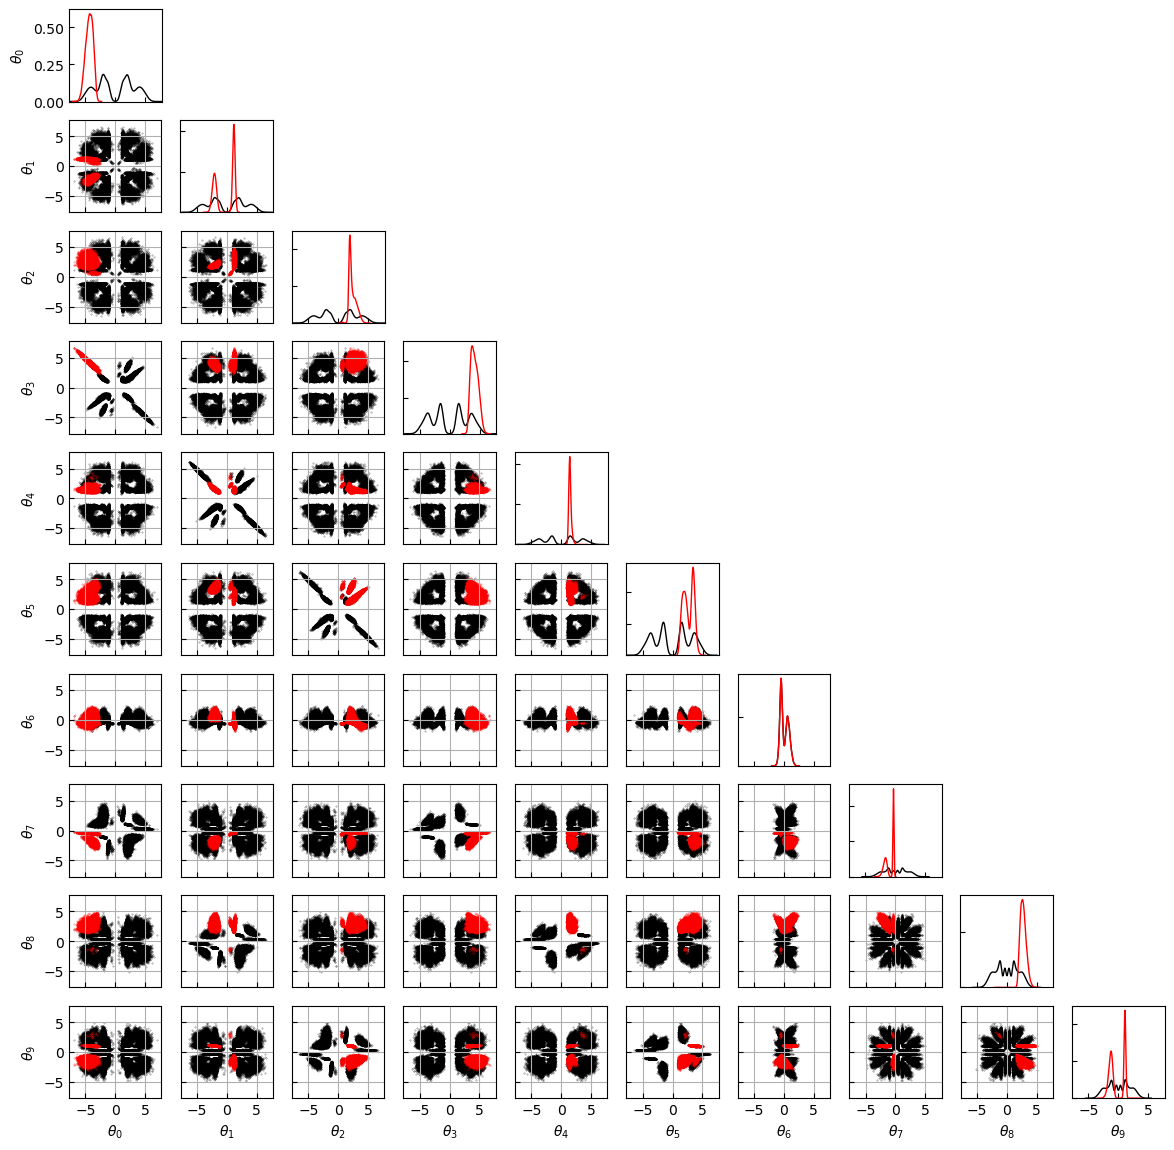

In [21]:
figure = visualization.TriangleFigure(
    prefix=r"\theta",
    #ax_width=4.0,
    #ax_height=4.0,
    settings=visualization.TriangleSettings(
        scatter_settings=visualization.ScatterSettings(alpha=0.5, size=0.1)
    )
)
figure.plot(data=fullset[:49152], data_2=subset)

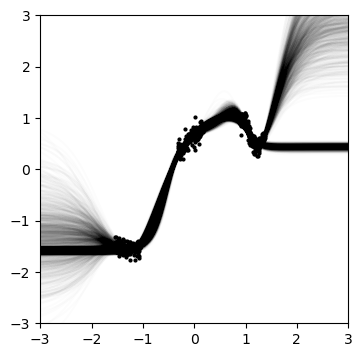

In [22]:
figure = visualization.RegressionFigure(
    settings=visualization.RegressionSettings(
        transformation_plot_settings=visualization.TransformationPlotSettings(alpha=0.01)
    )
)
figure.plot(data=dataset_train.data, transformation=neural_network.apply_from_vector, parameters=fullset[:2048], std=0.1)

In [23]:
# disect non-symmetric area into smaller cluster

In [24]:
selection_1 = np.argwhere((mirrored_parameters_samples[:, 1] > 0.0) * 1.0).squeeze()
selection_2 = np.argwhere((mirrored_parameters_samples[:, 1] <= 0.0) * 1.0).squeeze()
set_1 = mirrored_parameters_samples[selection_1]
set_2 = mirrored_parameters_samples[selection_2]
print(set_1.shape, set_2.shape)
for i, (ele_1, ele_2) in enumerate(zip(set_1.mean(0), set_2.mean(0))):
    print(i, ele_1, "    ", ele_2)

(27717, 10) (21435, 10)
0 -4.6525216      -3.9024487
1 1.1921865      -2.0610883
2 2.677438      1.9695675
3 4.5148196      3.7062745
4 1.428717      1.5771017
5 2.0054433      3.4977243
6 -0.44833124      0.7204364
7 -0.33646432      -1.742781
8 2.526246      2.9545283
9 -1.3028702      1.0900602


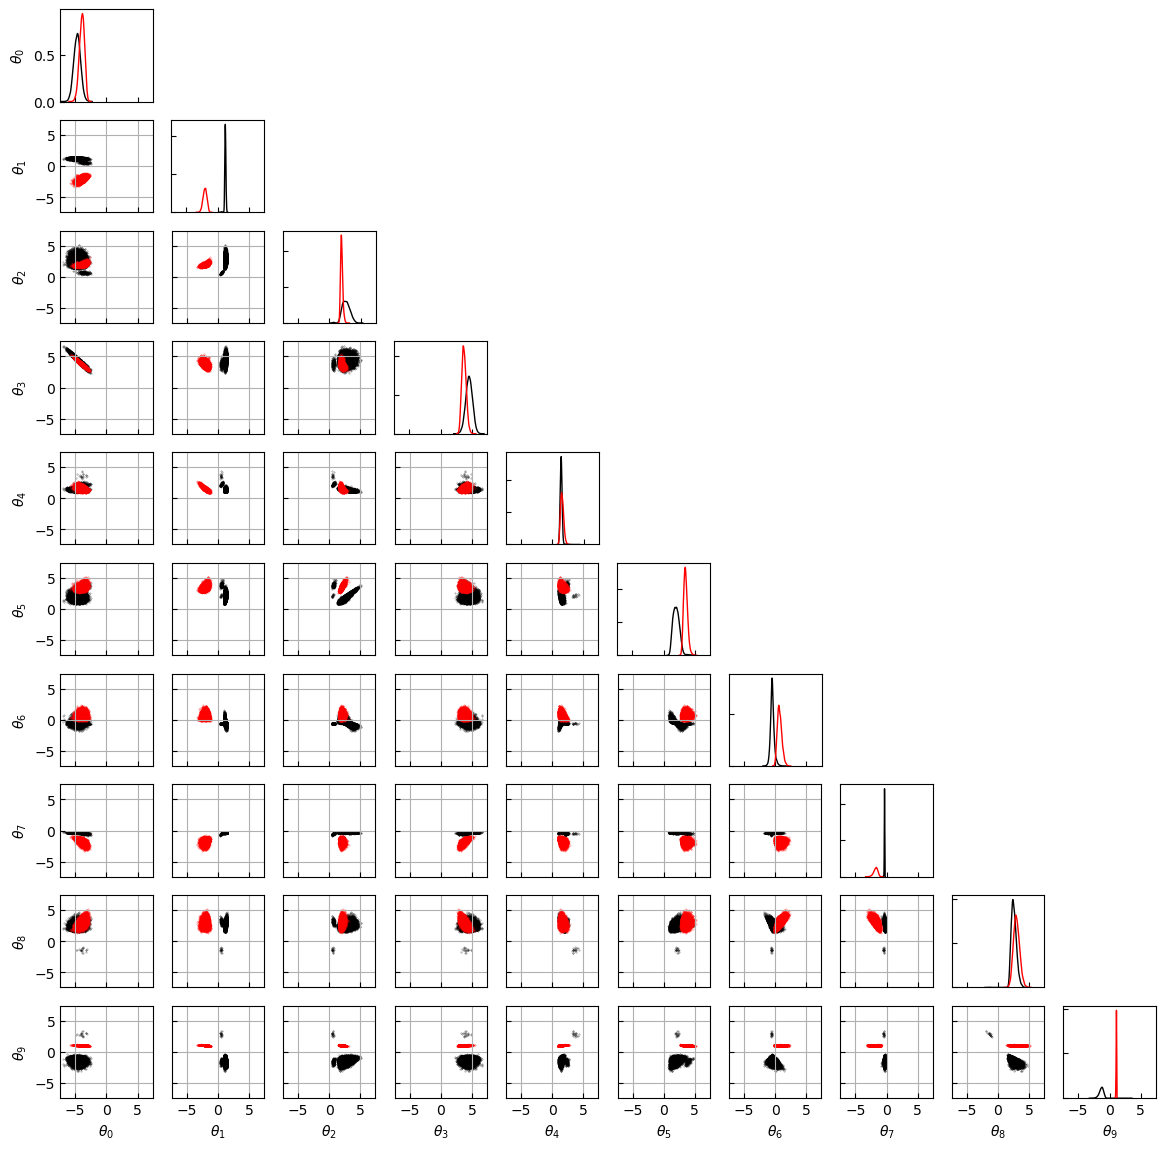

In [25]:
figure = visualization.TriangleFigure(
    prefix=r"\theta",
    #ax_width=4.0,
    #ax_height=4.0,
    settings=visualization.TriangleSettings(
        scatter_settings=visualization.ScatterSettings(alpha=0.5, size=0.1)
    )
)
figure.plot(data=set_1[:49152], data_2=set_2[:49152])

In [26]:
print(set_2.shape)
subset = set_2
fullset = []
counter = 0
for t1 in permutation_symmetries:
    for t2 in activation_symmetries:
        subset_transformed = subset @ t2 @ t1 # the order seems to be important!
        counter += 1
        fullset.append(subset_transformed)
fullset = np.concatenate(fullset, axis=0)
print(counter)

(21435, 10)
48


In [27]:
fullset = np.random.permutation(fullset)

In [28]:
set_2 = np.random.permutation(set_2)

In [29]:
set_1 = np.random.permutation(set_1)

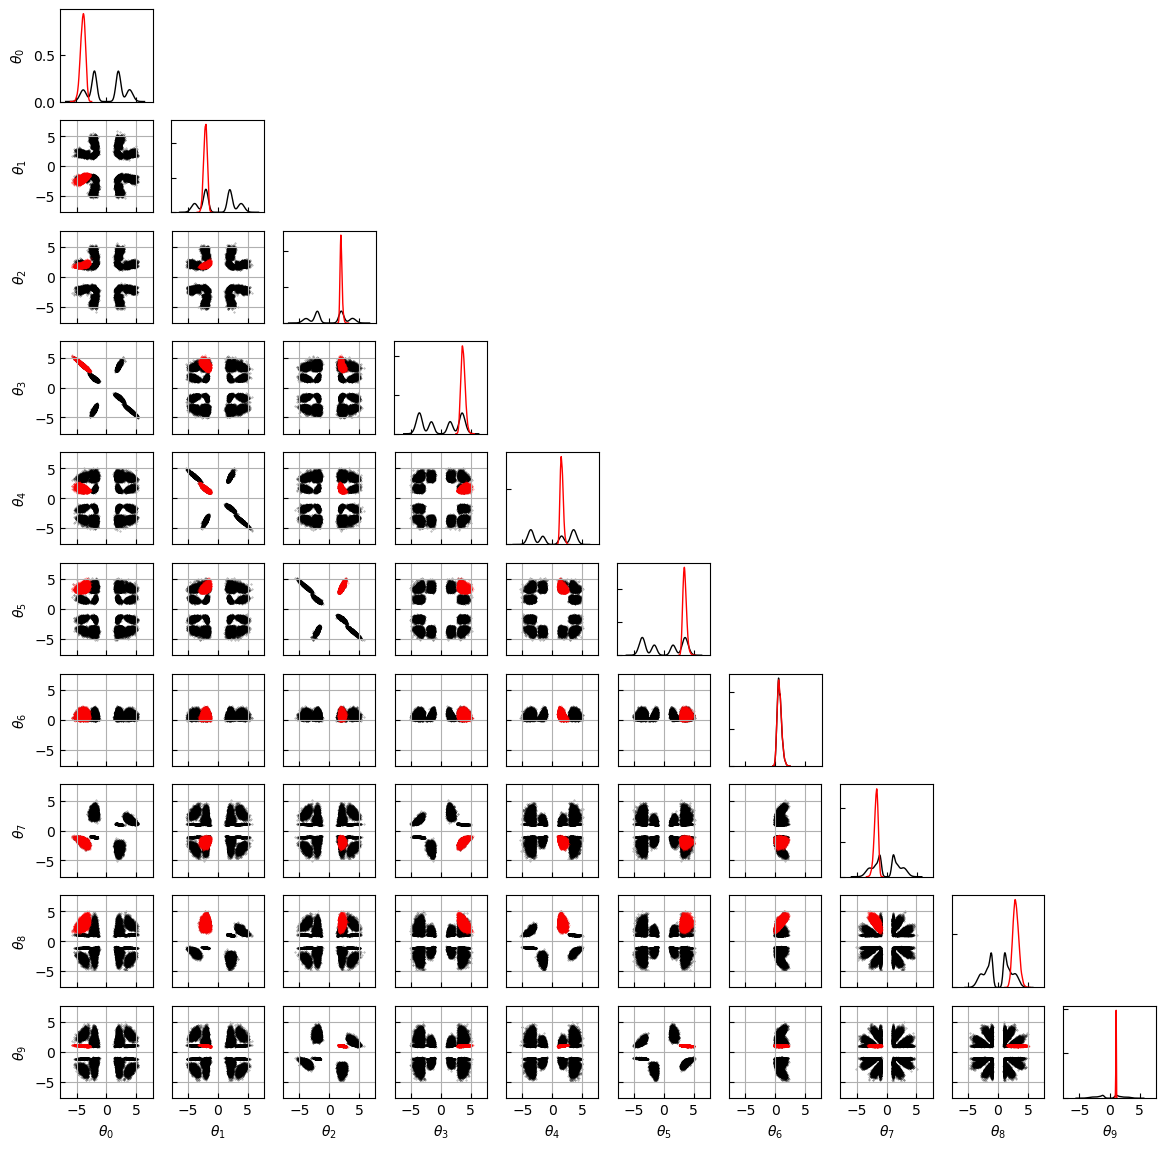

In [30]:
figure = visualization.TriangleFigure(
    prefix=r"\theta",
    #ax_width=4.0,
    #ax_height=4.0,
    settings=visualization.TriangleSettings(
        scatter_settings=visualization.ScatterSettings(alpha=0.5, size=0.1)
    )
)
figure.plot(data=fullset[:49152], data_2=subset[:49152])

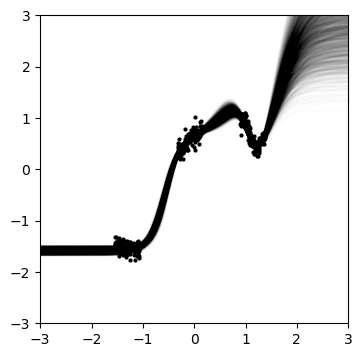

In [31]:
figure = visualization.RegressionFigure(
    settings=visualization.RegressionSettings(
        transformation_plot_settings=visualization.TransformationPlotSettings(alpha=0.01)
    )
)
figure.plot(data=dataset_train.data, transformation=neural_network.apply_from_vector, parameters=fullset[:2048], std=0.1)

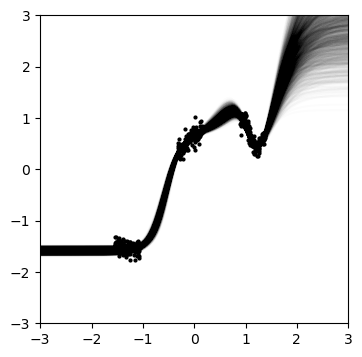

In [36]:
figure = visualization.RegressionFigure(
    settings=visualization.RegressionSettings(
        transformation_plot_settings=visualization.TransformationPlotSettings(alpha=0.01)
    )
)
figure.plot(data=dataset_train.data, transformation=neural_network.apply_from_vector, parameters=set_2[:2048], std=0.1)

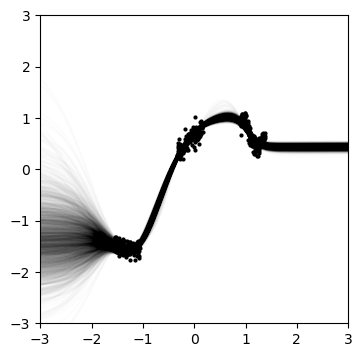

In [37]:
figure = visualization.RegressionFigure(
    settings=visualization.RegressionSettings(
        transformation_plot_settings=visualization.TransformationPlotSettings(alpha=0.01)
    )
)
figure.plot(data=dataset_train.data, transformation=neural_network.apply_from_vector, parameters=set_1[:2048], std=0.1)

In [34]:
selection_3 = np.argwhere((set_1[:, 9] > 0.0) * 1.0).squeeze()
selection_4 = np.argwhere((set_1[:, 9] <= 0.0) * 1.0).squeeze()
set_1_a = set_1[selection_3]
set_1_b = set_1[selection_4]
print(set_1_a.shape, set_1_b.shape)

(22, 10) (27695, 10)


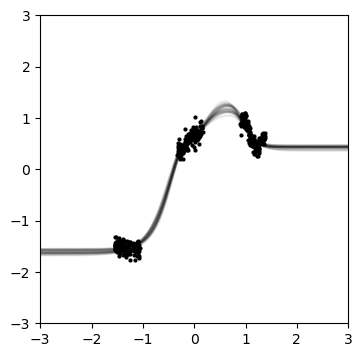

In [42]:
figure = visualization.RegressionFigure(
    settings=visualization.RegressionSettings(
        transformation_plot_settings=visualization.TransformationPlotSettings(alpha=0.1)
    )
)
figure.plot(data=dataset_train.data, transformation=neural_network.apply_from_vector, parameters=set_1_a[:2048], std=0.1)

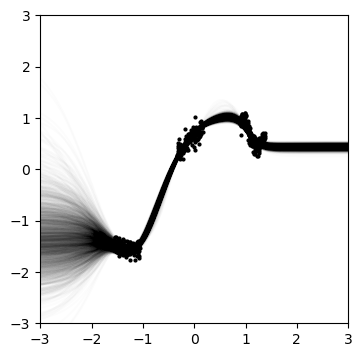

In [39]:
figure = visualization.RegressionFigure(
    settings=visualization.RegressionSettings(
        transformation_plot_settings=visualization.TransformationPlotSettings(alpha=0.01)
    )
)
figure.plot(data=dataset_train.data, transformation=neural_network.apply_from_vector, parameters=set_1_b[:2048], std=0.1)

In [40]:
print((set_1_b[:, 1]<0.8).sum())

181


In [41]:
selection_5 = np.argwhere((set_1_b[:, 1] > 0.8) * 1.0).squeeze()
selection_6 = np.argwhere((set_1_b[:, 1] <= 0.8) * 1.0).squeeze()
set_1_c = set_1_b[selection_5]
set_1_d = set_1_b[selection_6]
print(set_1_c.shape, set_1_d.shape)

(27514, 10) (181, 10)


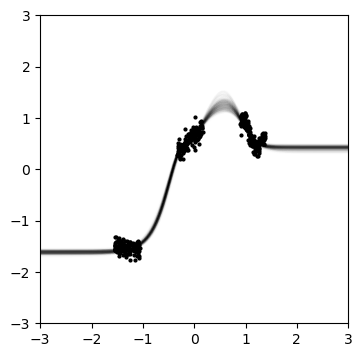

In [43]:
figure = visualization.RegressionFigure(
    settings=visualization.RegressionSettings(
        transformation_plot_settings=visualization.TransformationPlotSettings(alpha=0.01)
    )
)
figure.plot(data=dataset_train.data, transformation=neural_network.apply_from_vector, parameters=set_1_d[:2048], std=0.1)

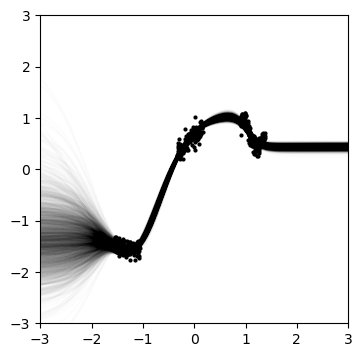

In [44]:
figure = visualization.RegressionFigure(
    settings=visualization.RegressionSettings(
        transformation_plot_settings=visualization.TransformationPlotSettings(alpha=0.01)
    )
)
figure.plot(data=dataset_train.data, transformation=neural_network.apply_from_vector, parameters=set_1_c[:2048], std=0.1)